# pyxem


### A 4-D STEM Package in the Hyperspy Ecosystem

#### Carter Francis, University of Wisconsin Madison
#### *June 13, 2023*

# 4-D STEM Rich in Information (and in Size)

<img src="Images/4DSTEM.gif" alt="4D STEM GIF">

# Using pyxem 

Because pyxem integrates with hyperspy importing hyperspy will automatically load pyxem if it is installed. We can load and visualize the same dataset 

In [2]:
import hyperspy.api as hs
hs.set_log_level("ERROR")

In [3]:
hs.print_known_signal_types()

signal_type,aliases,class name,package
beam_shift,,BeamShift,pyxem
CL_SEM,"CLSEM, cathodoluminescence SEM",CLSEMSpectrum,lumispy
CL_STEM,"CLSTEM, cathodoluminescence STEM",CLSTEMSpectrum,lumispy
CL,"CLSpectrum, cathodoluminescence",CLSpectrum,lumispy
correlation,,Correlation1D,pyxem
correlation,,Correlation2D,pyxem
dpc,,DPCBaseSignal,pyxem
dpc,,DPCSignal1D,pyxem
dpc,,DPCSignal2D,pyxem
DielectricFunction,dielectric function,DielectricFunction,hyperspy


<ElectronDiffraction2D, title: , dimensions: (54, 57|72, 72)>


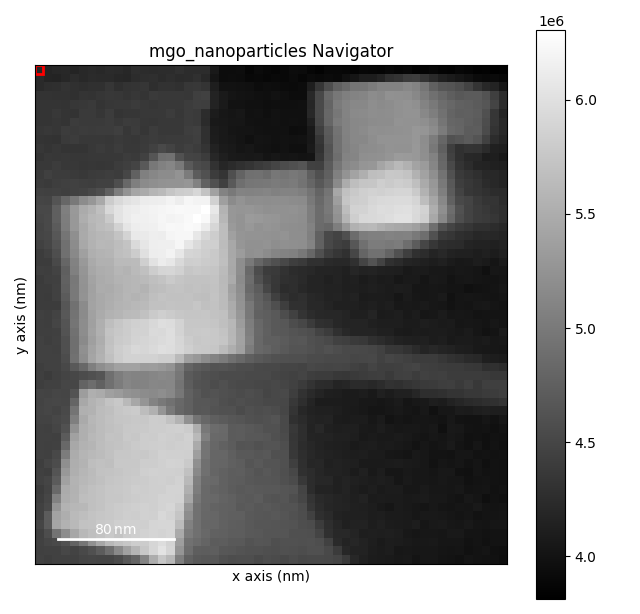

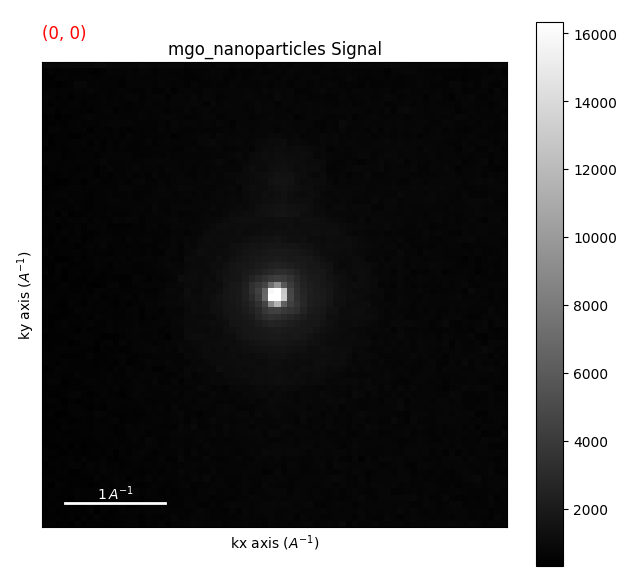

In [5]:
%matplotlib widget
dp = hs.load("data/mgo_nanoparticles.zspy") # Use Zarr backend for speed and load lazily cause we can
dp.plot()

# Pyxem Dependacy (Family) Tree

<img src="DependancyTree.svg" alt="Dependancy Tree">

# Extending Hyperspy's Capabilities

Pyxem works _with_ hyperspy to manage very large datasets. In order to acomplish this pyxem makes heavy use of:

- Lazy operations including lazy loading of data and lazy plotting
- Efficient loading of data from file (using primarily the .zarr file specificiation)
- Scalibility through Dask allowing running on a single core to running distributed clustering computing

All together pyxem offers _fast_ scalable performance across the board paired with the great tools for visualization offered through hyperspy

<center>
<img src="Images/zarr-pink-horizontal.svg" alt="ZARR" width="400" height="400">  <img src="Images/dask_horizontal.svg" alt="DASK" width="400" height="400" ></center>

# Why 

- 

# Loading and Operating on Data

Let's look at what loading data in pyxem looks like 

In [4]:
dp = hs.load("data/mgo_nanoparticles.zspy",
             lazy=True) # Use Zarr backend for speed and load lazily cause we can

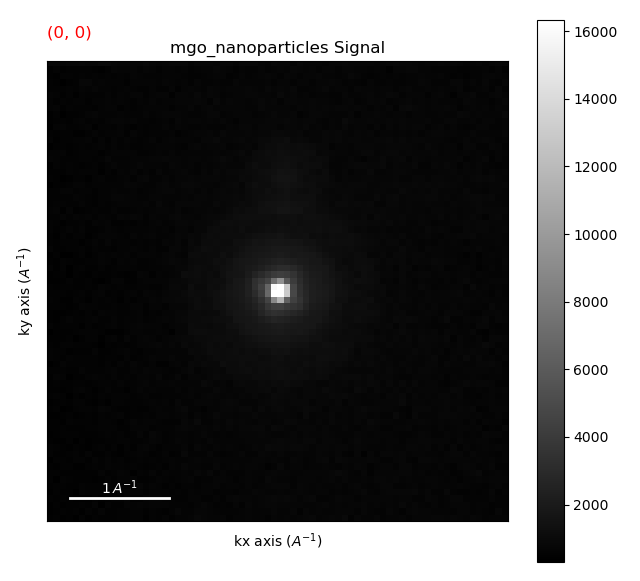

In [7]:
dp.plot(navigator="slider")

## Let's Make Some Virtual Images

We can construct Virtual Bright Field and Virtual DarkField Images very easily

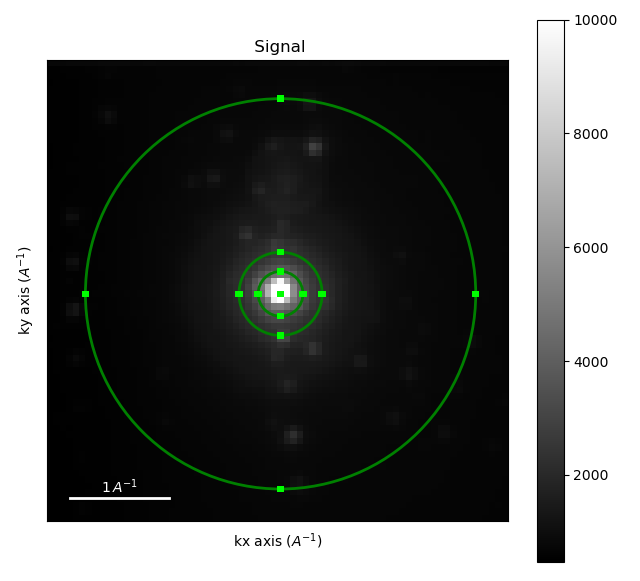

In [102]:
mean_cbed = dp.mean()
mean_cbed.plot(vmax=10000)
bf_roi = hs.roi.CircleROI(cx=0, cy=0, r= 0.2)
bf_roi.add_widget(mean_cbed)

df_roi = hs.roi.CircleROI(cx=0, cy=0, r_inner= 0.4, r=2.)
df_roi.add_widget(mean_cbed)

[<AxesSubplot:title={'center':'Bright Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':'Dark Field'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

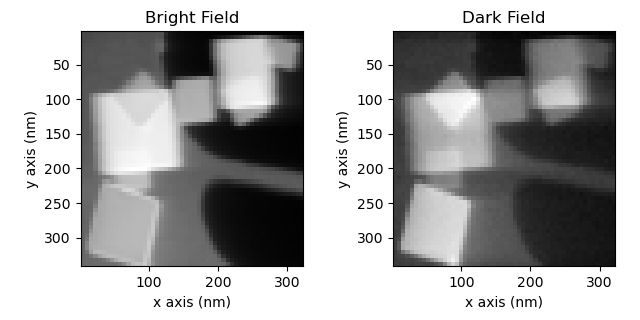

In [108]:
bf = dp.get_integrated_intensity(bf_roi)
df =  dp.get_integrated_intensity(df_roi)
hs.plot.plot_images([bf, df], label=["Virtual Bright Field", "Virtual Dark Field"], tight_layout=True, colorbar=None)

## Lazy Data in Pyxem
1. Allows you to operate on datasets larger than available memory 
2. Increases parallelism
3. Allows you to split operations easily across many machienes
4. Simplifies and speeds up your workflows. 

In [11]:
display(dp) # show the dataset/chunking

<LazyElectronDiffraction2D, title: , dimensions: (54, 57|72, 72)>